<a href="https://colab.research.google.com/github/Ajita3/AICourseworkTopicClassification/blob/Ajita3-patch-1/ChildMortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# importing necessary Libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


In [4]:
# reading the data and taking out top 5 rows

df = pd.read_csv("Data.csv")
df.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,MORT_100,"Number of deaths in children aged <5 years, by...",numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN,2024-03-24T18:15:00.000Z
1,MORT_100,"Number of deaths in children aged <5 years, by...",numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN,2024-03-24T18:15:00.000Z
2,MORT_100,"Number of deaths in children aged <5 years, by...",numeric,EUR,Europe,Country,ALB,Albania,Year,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN,2024-03-24T18:15:00.000Z
3,MORT_100,"Number of deaths in children aged <5 years, by...",numeric,EUR,Europe,Country,ALB,Albania,Year,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN,2024-03-24T18:15:00.000Z
4,MORT_100,"Number of deaths in children aged <5 years, by...",numeric,AFR,Africa,Country,DZA,Algeria,Year,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN,2024-03-24T18:15:00.000Z


In [5]:
df_model = df[[
    "Location",          # Country
    "ParentLocation",    # Region
    "Dim2",              # AgeGroup
    "Period",            # Year
    "FactValueNumeric"   # Deaths
]].copy()

df_model.columns = ["Country", "Region", "AgeGroup", "Year", "Deaths"]

df_model = df_model.dropna()


In [6]:
# mortality class

threshold = df_model["Deaths"].median()

df_model["MortalityClass"] = (df_model["Deaths"] > threshold).astype(int)

df_model["MortalityClass"].value_counts()


,count
MortalityClass,
0,29197
1,29197


In [54]:
#encoding

from sklearn.preprocessing import LabelEncoder

enc_country = LabelEncoder()
enc_region = LabelEncoder()
enc_age = LabelEncoder()

df_model["Country"] = enc_country.fit_transform(df_model["Country"])
df_model["Region"] = enc_region.fit_transform(df_model["Region"])
df_model["AgeGroup"] = enc_age.fit_transform(df_model["AgeGroup"])


In [55]:
#train test split

from sklearn.model_selection import train_test_split

X = df_model[["Country", "Region", "AgeGroup", "Year"]]
y = df_model["MortalityClass"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [56]:
# training random forest classifier

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    random_state=42
)

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]


In [57]:
# training XGBoost CLassifier

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)[:, 1]


In [58]:
# training LGBM Classifier

from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)

lgbm.fit(X_train, y_train)
lgbm_preds = lgbm.predict(X_test)
lgbm_probs = lgbm.predict_proba(X_test)[:, 1]


[LightGBM] [Info] Number of positive: 21898, number of negative: 21897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 43795, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000046
[LightGBM] [Info] Start training from score 0.000046


In [59]:
# Performance Metrics like Accuracy Score, Precision Score, Recall Score, F1-Score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(y_test, preds, name):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds))
    print("Recall:", recall_score(y_test, preds))
    print("F1 Score:", f1_score(y_test, preds))

evaluate(y_test, rf_preds, "Random Forest")
evaluate(y_test, xgb_preds, "XGBoost")
evaluate(y_test, lgbm_preds, "LightGBM")



Random Forest
Accuracy: 0.7249126652510446
Precision: 0.7161290322580646
Recall: 0.7451705713111385
F1 Score: 0.7303612192829327

XGBoost
Accuracy: 0.7505308582779643
Precision: 0.7365153279006597
Recall: 0.7801068639539663
F1 Score: 0.757684630738523

LightGBM
Accuracy: 0.7559421878210837
Precision: 0.7416558861578266
Recall: 0.7854500616522812
F1 Score: 0.7629250116441546


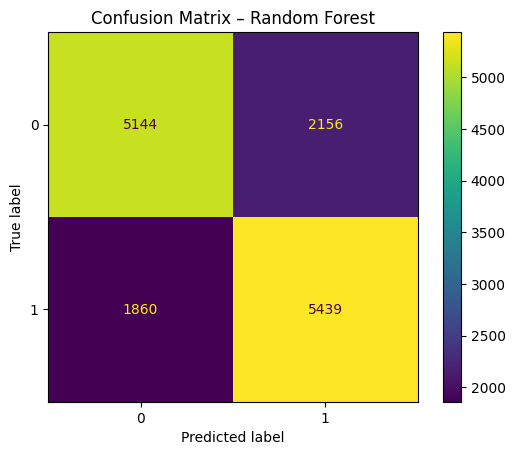

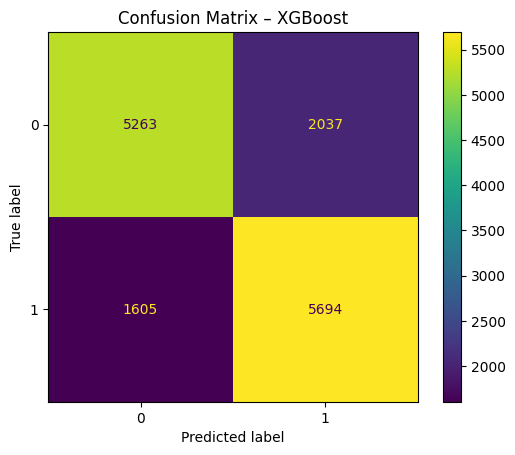

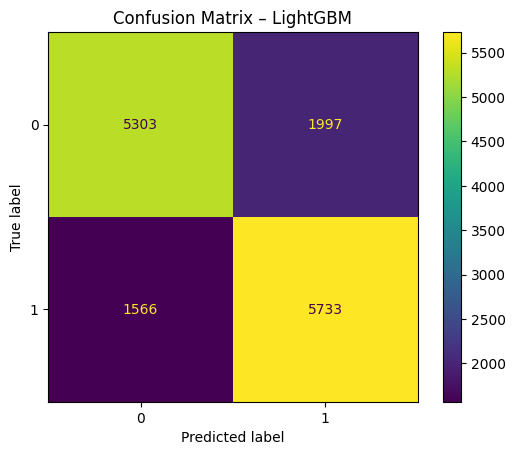

In [13]:
# Plotting Confusion Metrics

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "LightGBM": lgbm
}

for name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test
    )
    plt.title(f"Confusion Matrix – {name}")
    plt.show()


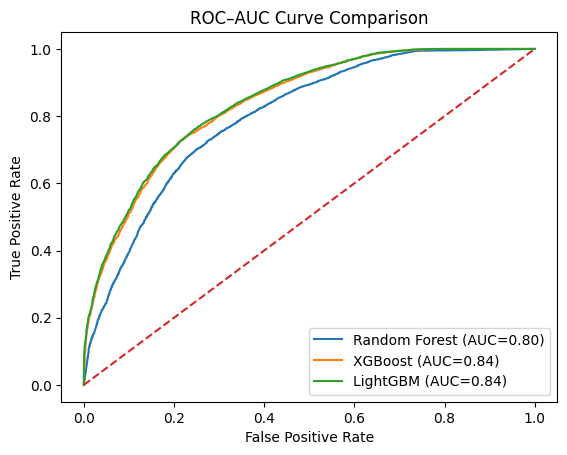

In [53]:
#Plotting ROC-AUC Curve

from sklearn.metrics import roc_curve, auc

plt.figure()

for name, probs in [
    ("Random Forest", rf_probs),
    ("XGBoost", xgb_probs),
    ("LightGBM", lgbm_probs)
]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve Comparison")
plt.legend()
plt.show()


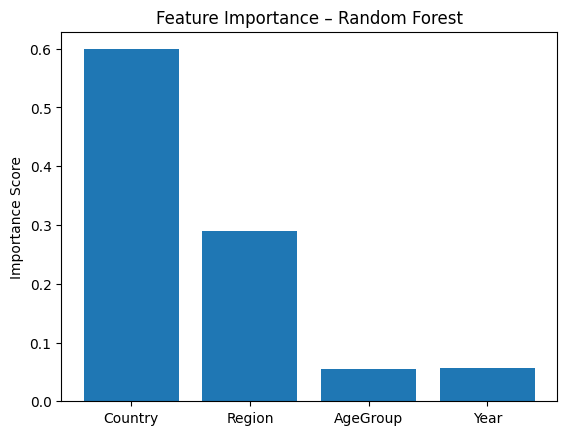

In [45]:
# Plotting Feature Importance of Random Forest

import numpy as np

features = X.columns

plt.figure()
plt.bar(features, rf.feature_importances_)
plt.title("Feature Importance – Random Forest")
plt.ylabel("Importance Score")
plt.show()


In [75]:

def predict_mortality(country, region, age_group, year):
    data = pd.DataFrame([{
        "Country": enc_country.transform([country])[0],
        "Region": enc_region.transform([region])[0],
        "AgeGroup": enc_age.transform([age_group])[0],
        "Year": year
    }])

    return {
        "Random Forest": rf.predict(data)[0],
        "XGBoost": xgb.predict(data)[0],
        "LightGBM": lgbm.predict(data)[0]
    }


In [64]:
X_nn = df_model[["Country_enc", "Region_enc", "AgeGroup_enc", "Year"]]
y_nn = df_model["MortalityClass"]


In [65]:
scaler = StandardScaler()
X_nn_scaled = scaler.fit_transform(X_nn)


In [66]:
# Train - Test Split

from sklearn.model_selection import train_test_split

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn_scaled, y_nn, test_size=0.25, random_state=42, stratify=y_nn
)


In [67]:
# Import tensorflow

import tensorflow as tf
print(tf.__version__)




2.19.0


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [25]:
nn_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')   # Binary output
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [27]:
history = nn_model.fit(
    X_train_nn,
    y_train_nn,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1
)


Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6031 - loss: 0.6646 - val_accuracy: 0.6348 - val_loss: 0.6361
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6355 - loss: 0.6359 - val_accuracy: 0.6396 - val_loss: 0.6321
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6368 - loss: 0.6332 - val_accuracy: 0.6406 - val_loss: 0.6310
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6453 - loss: 0.6290 - val_accuracy: 0.6487 - val_loss: 0.6272
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6492 - loss: 0.6265 - val_accuracy: 0.6521 - val_loss: 0.6251
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6450 - loss: 0.6266 - val_accuracy: 0.6504 - val_loss: 0.6235
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6494 - loss: 0.6221 - val_accuracy: 0.6573 - val_loss: 0.6204
Epoch 8/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6551 - loss: 0.6179 - val_accuracy: 0.

In [28]:

nn_loss, nn_accuracy = nn_model.evaluate(X_test_nn, y_test_nn)
print("Neural Network Accuracy:", nn_accuracy) # Neural Network Accuracy


457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6772 - loss: 0.5994
Neural Network Accuracy: 0.6797040700912476


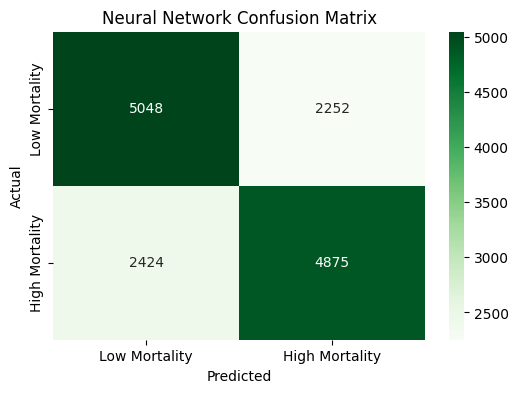

In [30]:
# Neural Network - Confusion Matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_nn = confusion_matrix(y_test_nn, nn_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_nn,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Low Mortality", "High Mortality"],
    yticklabels=["Low Mortality", "High Mortality"]
)
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [31]:
# Performance Metrics Like Precision Score, Recall Score, F1-Score

from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(y_test_nn, nn_pred))
print("Recall:", recall_score(y_test_nn, nn_pred))
print("F1 Score:", f1_score(y_test_nn, nn_pred))


Precision: 0.6840185211168794
Recall: 0.6678997122893547
F1 Score: 0.675863025093581


In [36]:
def predict_mortality_nn(country, region, age_group, year):
    country_enc = enc_country.transform([country])[0]
    region_enc = enc_region.transform([region])[0]
    age_enc = enc_age.transform([age_group])[0]

    X_new = np.array([[country_enc, region_enc, age_enc, year]])
    X_new_scaled = scaler.transform(X_new)

    prob = nn_model.predict(X_new_scaled)[0][0]
    prediction = int(prob > 0.5)

    return {
        "MortalityClass": prediction,
        "Meaning": "High Mortality" if prediction == 1 else "Low Mortality",
        "Probability": prob
    }


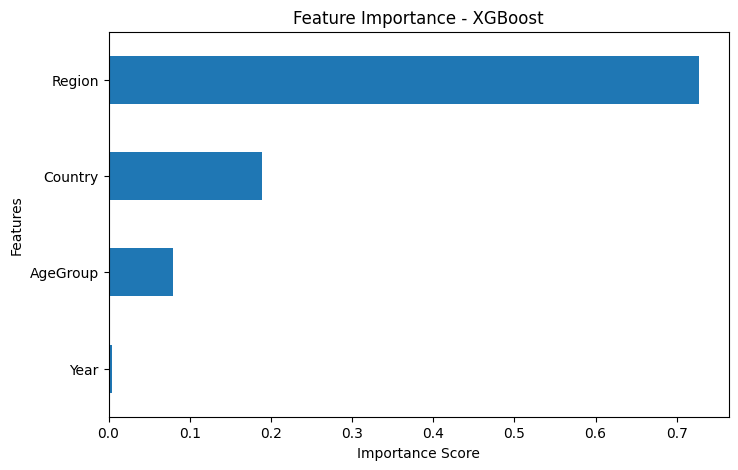

In [42]:
# XGBoost feature importance
xgb_importance = pd.Series(
    xgb.feature_importances_,
    index=X.columns
).sort_values()

plt.figure(figsize=(8, 5))
xgb_importance.plot(kind="barh")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()



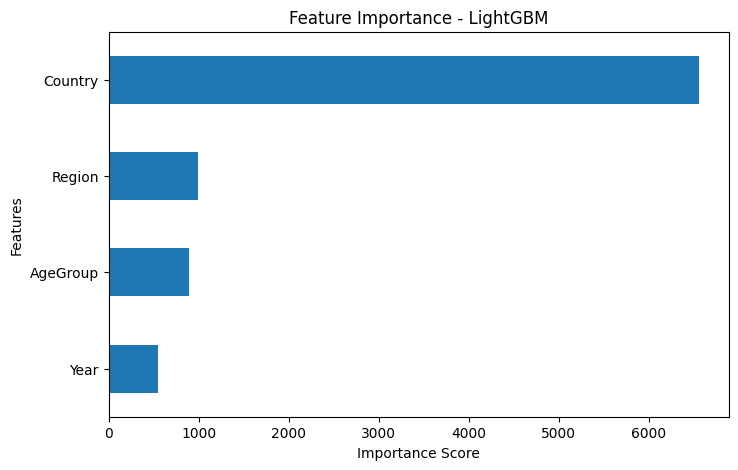

In [44]:
# LightGBM feature importance
lgb_importance = pd.Series(
    lgbm.feature_importances_,
    index=X.columns
).sort_values()

plt.figure(figsize=(8, 5))
lgb_importance.plot(kind="barh")
plt.title("Feature Importance - LightGBM")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()
